<a href="https://colab.research.google.com/github/danicardonaibz/molecular_equilibrium/blob/main/ML_Material_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project in machine Learning for Materials Science

https://github.com/tonyreina/chemistry/blob/main/chemistry_predict_logP_tensorflow.ipynb

In [ ]:
# First we will install some dependencies

%pip install --upgrade py3Dmol
%pip install --upgrade ase
%pip install --upgrade pubchempy
%pip install --upgrade dscribe
%pip install git+https://github.com/samoturk/mol2vec
%pip install --upgrade rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-y84urdch
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-y84urdch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
from itertools import zip_longest
from collections import defaultdict

import json
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit import Chem

import ase
from ase import Atoms
from dscribe.descriptors import MBTR, CoulombMatrix
from rdkit.Chem import Descriptors

from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

import random

import tensorflow as tf

## Step 1: Loading our data

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
df = pd.read_json("/content/drive/MyDrive/m1507656/df_62k.json", orient='split')

In [ ]:
df.head(4)

,refcode_csd,canonical_smiles,inchi,number_of_atoms,xyz_pbe_relaxed,energies_occ_pbe,energies_occ_pbe0_vac_tier2,energies_occ_pbe0_water,energies_occ_pbe0_vac_tzvp,energies_occ_pbe0_vac_qzvp,...,energies_unocc_gw_qzvp,cbs_unocc_gw,total_energy_pbe,total_energy_pbe0_vac_tier2,total_energy_pbe0_water,total_energy_pbe0_vac_tzvp,total_energy_pbe0_vac_qzvp,hirshfeld_pbe,hirshfeld_pbe0_vac_tier2,hirshfeld_pbe0_water
0,ABAFEQ,Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...,InChI=1S/C18H18ClN3O3S2/c1-12-3-9-16(10-4-12)2...,45,45\n\nO 39.55724515 33.75271314 ...,"[-2759.71553, -2416.30896, -2412.55736, -513.9...","[-2788.05127, -2443.36662, -2439.20276, -526.4...",None,None,None,...,None,None,-63908.261677,-63911.485930,NaN,NaN,NaN,"[-0.27470711000000003, 0.44228032, -0.26425776...","[-0.29802765000000003, 0.47691104, -0.28757556...",None
1,ABEDOC,N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...,InChI=1S/C28H22N2O2S/c29-21-26(27(22-13-5-1-6-...,55,55\n\nC 8.74281024 13.44863575 ...,"[-2416.32097, -510.97599, -510.93427, -382.106...","[-2443.36734, -523.36541, -523.31866, -392.998...",None,None,None,...,None,None,-47344.131203,-47346.537633,NaN,NaN,NaN,"[-0.04383635, 0.0489517, -0.04317942, 0.049465...","[-0.04511281, 0.05043578, -0.04467607, 0.05086...",None
2,LODZOT,n1ccc(cc1)c1nnc(o1)c1cccs1\t\n,InChI=1S/C11H7N3OS/c1-2-9(16-7-1)11-14-13-10(1...,23,23\n\nN 23.84904338 42.50577669 ...,"[-2412.75371, -513.88451, -382.11294, -382.041...","[-2439.38001, -526.39732, -393.09445, -393.002...",None,None,None,...,None,None,-28915.979909,-28916.826630,NaN,NaN,NaN,"[-0.15366001, 0.01755584, 0.05299325, -0.04774...","[-0.16233532, 0.02121239, 0.05594731, -0.06621...",None
3,LUSREW,CC/C=C(/S(=O)(=O)c1ccc(cc1)C)\F\t\n,"InChI=1S/C11H13FO2S/c1-3-4-11(12)15(13,14)10-7...",28,28\n\nC 36.52340453 39.64067030 ...,"[-2416.01387, -662.1882, -510.96036, -510.9032...","[-2443.06569, -676.06906, -523.38098, -523.310...","[-2443.54535, -676.3259, -523.94531, -523.9294...",None,None,...,None,None,-29310.525400,-29311.929019,-29312.152528,NaN,NaN,"[-0.10553088000000001, 0.052016810000000004, 0...","[-0.10641357, 0.053639570000000004, 0.05095191...","[-0.10396546, 0.06349725, 0.0567905, 0.0529875..."


In [ ]:
df.reset_index(inplace=True, drop = True)

In [ ]:
df.columns.tolist()

['refcode_csd',
 'canonical_smiles',
 'inchi',
 'number_of_atoms',
 'xyz_pbe_relaxed',
 'energies_occ_pbe',
 'energies_occ_pbe0_vac_tier2',
 'energies_occ_pbe0_water',
 'energies_occ_pbe0_vac_tzvp',
 'energies_occ_pbe0_vac_qzvp',
 'energies_occ_gw_tzvp',
 'energies_occ_gw_qzvp',
 'cbs_occ_gw',
 'energies_unocc_pbe',
 'energies_unocc_pbe0_vac_tier2',
 'energies_unocc_pbe0_water',
 'energies_unocc_pbe0_vac_tzvp',
 'energies_unocc_pbe0_vac_qzvp',
 'energies_unocc_gw_tzvp',
 'energies_unocc_gw_qzvp',
 'cbs_unocc_gw',
 'total_energy_pbe',
 'total_energy_pbe0_vac_tier2',
 'total_energy_pbe0_water',
 'total_energy_pbe0_vac_tzvp',
 'total_energy_pbe0_vac_qzvp',
 'hirshfeld_pbe',
 'hirshfeld_pbe0_vac_tier2',
 'hirshfeld_pbe0_water']

## Step 2: Preprocessing the data

### 2.1: Subsetting the dataframe

In [ ]:
relevant_columns = ['refcode_csd', 'canonical_smiles',  'number_of_atoms', 'xyz_pbe_relaxed', 'total_energy_pbe']
df_subset = df[relevant_columns]
df_subset.head()

,refcode_csd,canonical_smiles,number_of_atoms,xyz_pbe_relaxed,total_energy_pbe
0,ABAFEQ,Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...,45,45\n\nO 39.55724515 33.75271314 ...,-63908.261677
1,ABEDOC,N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...,55,55\n\nC 8.74281024 13.44863575 ...,-47344.131203
2,LODZOT,n1ccc(cc1)c1nnc(o1)c1cccs1\t\n,23,23\n\nN 23.84904338 42.50577669 ...,-28915.979909
3,LUSREW,CC/C=C(/S(=O)(=O)c1ccc(cc1)C)\F\t\n,28,28\n\nC 36.52340453 39.64067030 ...,-29310.525400
4,NOMBEA01,OC(=O)c1cc(N(=O)=O)c(c(c1)N(=O)=O)C\t\n,22,22\n\nC 3.95256786 17.67855833 24.82877401 \nN...,-23659.206412


### 2.2: Cleaning canonical SMILES
They happen to have \t\n characters to indicate end of line. These are going to be removed using a regex expression to match the rest of the strings.

In [ ]:
df_subset["canonical_smiles"]

0        Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...
1        N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...
2                           n1ccc(cc1)c1nnc(o1)c1cccs1\t\n
3                      CC/C=C(/S(=O)(=O)c1ccc(cc1)C)\F\t\n
4                  OC(=O)c1cc(N(=O)=O)c(c(c1)N(=O)=O)C\t\n
                               ...                        
61484    COC(=O)c1c(c(C(=O)OC)c(c(c1C(C)(C)C)C(=O)OC)C(...
61485             O=C(c1ccccc1O)N/N=C/c1ccc(c(c1)Cl)Cl\t\n
61486         C1=CC=C2C[C]([CH]1)[C]1[CH]C=CC=C(C1)CC2\t\n
61487    Cc1ccc(cc1)S(=O)(=O)N[C@H](C(=O)N1C(=O)OC[C@@H...
61488    OC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)c1n[nH]c2c1nc...
Name: canonical_smiles, Length: 61489, dtype: object

In [ ]:
regex = "\\t\\n"
df_subset["canonical_smiles"]=df_subset["canonical_smiles"].apply(lambda x: re.sub(regex, "", x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_subset.head(2)

,refcode_csd,canonical_smiles,number_of_atoms,xyz_pbe_relaxed,total_energy_pbe
0,ABAFEQ,Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...,45,45\n\nO 39.55724515 33.75271314 ...,-63908.261677
1,ABEDOC,N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...,55,55\n\nC 8.74281024 13.44863575 ...,-47344.131203


###2.2: Converting SMILES strings to RD-Kit molecules

In [ ]:
df_subset["mol"] = df_subset["canonical_smiles"].apply(lambda x: (Chem.MolFromSmiles(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RD-Kit outputs NoneType when fails to parse a SMILES string. Thus, to prevent exceptions when applying further transformations to the dataset, conflicting molecules are going to be removed.

In [ ]:
df_subset_clean = df_subset[df_subset['mol'].apply(lambda x: x is not None)].reset_index(drop=True)
len(df_subset), len(df_subset_clean)

(61489, 61037)

In [ ]:
# Adding hydrogen atoms to the molecules
df_subset_clean['mol'] = df_subset_clean['mol'].apply(lambda x: Chem.AddHs(x))

In [ ]:
df_subset_clean.head(2)

,refcode_csd,canonical_smiles,number_of_atoms,xyz_pbe_relaxed,total_energy_pbe,mol
0,ABAFEQ,Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...,45,45\n\nO 39.55724515 33.75271314 ...,-63908.261677,<rdkit.Chem.rdchem.Mol object at 0x7f5aae12fc90>
1,ABEDOC,N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...,55,55\n\nC 8.74281024 13.44863575 ...,-47344.131203,<rdkit.Chem.rdchem.Mol object at 0x7f5aae12fb10>


###2.3: Reshaping XYZ coordinates
TODO: apply MBTR to xyz to make a proper descriptor out of the atomic positions


In [ ]:
df.iloc[0].xyz_pbe_relaxed

'45\n\nO      39.55724515      33.75271314      38.40917207 \nS      40.85906611      34.05164612      38.96498639 \nO      42.08066828      33.95284000      38.19595313 \nC      42.32571194      32.73322762      40.89834532 \nH      43.19968501      32.99032401      40.30295436 \nCl      45.20041227      29.36338131      46.43043646 \nC      41.05184934      33.09086636      40.45377016 \nC      42.45668317      32.04677947      42.10437138 \nH      43.45084814      31.76806349      42.45397500 \nC      41.33623713      31.70625411      42.87422993 \nC      40.06720668      32.07018496      42.39744704 \nH      39.18097405      31.80058002      42.97364913 \nC      39.91665528      32.75758494      41.19816166 \nH      38.92751728      33.01994634      40.82523353 \nC      41.48361320      30.98558291      44.18381422 \nH      42.41118162      30.40352859      44.22479339 \nH      40.63985814      30.30766109      44.36544785 \nH      41.51361125      31.70368231      45.01623603 \nC 

In [ ]:
df_subset_clean.iloc[0].xyz_pbe_relaxed.split()[1:9]

['O',
 '39.55724515',
 '33.75271314',
 '38.40917207',
 'S',
 '40.85906611',
 '34.05164612',
 '38.96498639']

In [ ]:
df_subset_clean.iloc[0].xyz_pbe_relaxed.split()[:10]

['45',
 'O',
 '39.55724515',
 '33.75271314',
 '38.40917207',
 'S',
 '40.85906611',
 '34.05164612',
 '38.96498639',
 'O']

In [ ]:
def grouper(iterable, n, fillvalue=None):
  """
  This function splits the xyz array into N groups of 3 components, where N is
  the number of atoms in the molecule
  """
  args = [iter(iterable)] * n
  return list(zip_longest(*args, fillvalue=fillvalue))

In [ ]:
def positions_to_dict(raw_xyz):
  """
  Takes in a string of xyz atom positions and returns a dict of atom positions
  """
  # We use defaultdict dict subclass because instead of raising a KeyError provides 
  # a default value for the key that does not exist. In this case, we want a list-like
  # object
  data_dict = defaultdict(list) # Specify what are the value types

  iter_array =  [iter(raw_xyz.split()[1:])] * 4 # Multiplied by 4 because [atom name, x, y z]
  grouped_xyz = list(zip_longest(*iter_array, fillvalue=None))

  for i, element in enumerate(grouped_xyz):
    data_dict[element[0]].append(list(element[1:]))
  
  return dict(data_dict)

In [ ]:
df_subset_clean['xyz_pbe_relaxed'] = df_subset_clean['xyz_pbe_relaxed'].apply(positions_to_dict)

### 2.4: Getting some insights of the data

In [ ]:
# Tagging each molecule with the contained atom species
df_subset_clean['species'] = df_subset_clean['xyz_pbe_relaxed'].apply(lambda x:
                                                                      set(x.keys()))

In [ ]:
df_subset_clean.head()

,refcode_csd,canonical_smiles,number_of_atoms,xyz_pbe_relaxed,total_energy_pbe,mol,species
0,ABAFEQ,Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...,45,"{'O': [['39.55724515', '33.75271314', '38.4091...",-63908.261677,<rdkit.Chem.rdchem.Mol object at 0x7f5aae12fc90>,"{O, C, S, N, H, Cl}"
1,ABEDOC,N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...,55,"{'C': [['8.74281024', '13.44863575', '23.16378...",-47344.131203,<rdkit.Chem.rdchem.Mol object at 0x7f5aae12fb10>,"{O, C, S, N, H}"
2,LODZOT,n1ccc(cc1)c1nnc(o1)c1cccs1,23,"{'N': [['23.84904338', '42.50577669', '35.0388...",-28915.979909,<rdkit.Chem.rdchem.Mol object at 0x7f5aae135450>,"{O, C, S, N, H}"
3,LUSREW,CC/C=C(/S(=O)(=O)c1ccc(cc1)C)\F,28,"{'C': [['36.52340453', '39.64067030', '25.1692...",-29310.525400,<rdkit.Chem.rdchem.Mol object at 0x7f5aae135570>,"{O, F, C, S, H}"
4,NOMBEA01,OC(=O)c1cc(N(=O)=O)c(c(c1)N(=O)=O)C,22,"{'C': [['3.95256786', '17.67855833', '24.82877...",-23659.206412,<rdkit.Chem.rdchem.Mol object at 0x7f5aae135510>,"{N, C, H, O}"


In [ ]:
unique_species = list(set.union(*df_subset_clean.species.to_numpy()))

In [ ]:
unique_atomics = list(zip(unique_species,  
                          ase.Atoms(unique_species).get_atomic_numbers()))
unique_atomics

[('Br', 35),
 ('Se', 34),
 ('B', 5),
 ('F', 9),
 ('C', 6),
 ('As', 33),
 ('Si', 14),
 ('S', 16),
 ('N', 7),
 ('H', 1),
 ('O', 8),
 ('I', 53),
 ('Te', 52),
 ('P', 15),
 ('Cl', 17),
 ('Li', 3)]

In [ ]:
# Sort by atomic number
unique_atomics_sorted = sorted(unique_atomics, key=lambda t: t[1])
unique_atomics_sorted

[('H', 1),
 ('Li', 3),
 ('B', 5),
 ('C', 6),
 ('N', 7),
 ('O', 8),
 ('F', 9),
 ('Si', 14),
 ('P', 15),
 ('S', 16),
 ('Cl', 17),
 ('As', 33),
 ('Se', 34),
 ('Br', 35),
 ('Te', 52),
 ('I', 53)]

In [ ]:
unique_species_sorted = list(zip(*unique_atomics_sorted))
unique_species_sorted

[('H',
  'Li',
  'B',
  'C',
  'N',
  'O',
  'F',
  'Si',
  'P',
  'S',
  'Cl',
  'As',
  'Se',
  'Br',
  'Te',
  'I'),
 (1, 3, 5, 6, 7, 8, 9, 14, 15, 16, 17, 33, 34, 35, 52, 53)]

In [ ]:
# Creating dict with species frequency
unique_frequencies = []
for element in unique_species_sorted[0]:
  mask = df_subset_clean.species.apply(lambda x: element in x)
  unique_frequencies.append(list(mask).count(True))
frequencies = dict(zip(unique_species_sorted[0], unique_frequencies))
frequencies

{'H': 60745,
 'Li': 7,
 'B': 488,
 'C': 61012,
 'N': 40415,
 'O': 49621,
 'F': 4184,
 'Si': 2598,
 'P': 3594,
 'S': 14869,
 'Cl': 6943,
 'As': 136,
 'Se': 815,
 'Br': 4320,
 'Te': 121,
 'I': 827}

In [ ]:
# Setting seaborn plotting context
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

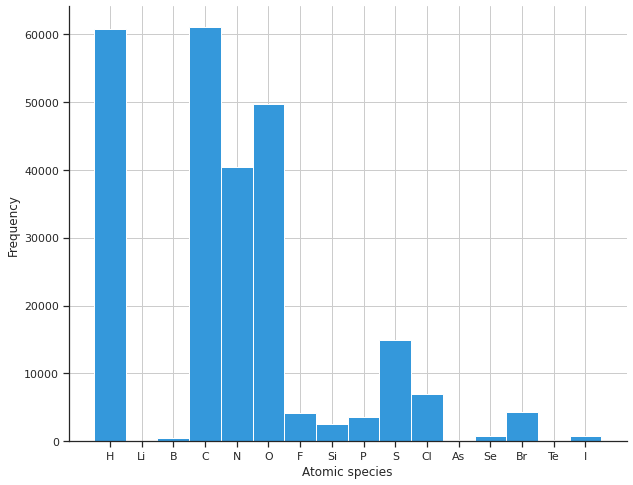

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x = frequencies.keys(), height = frequencies.values(), 
        color = '#3498DB', alpha = 1, width = 1)
ax.grid(True)
plt.ylabel('Frequency');
plt.xlabel('Atomic species');
plt.savefig('species_frequency.png', dpi = 600, bbox_inches = 'tight')
plt.show()

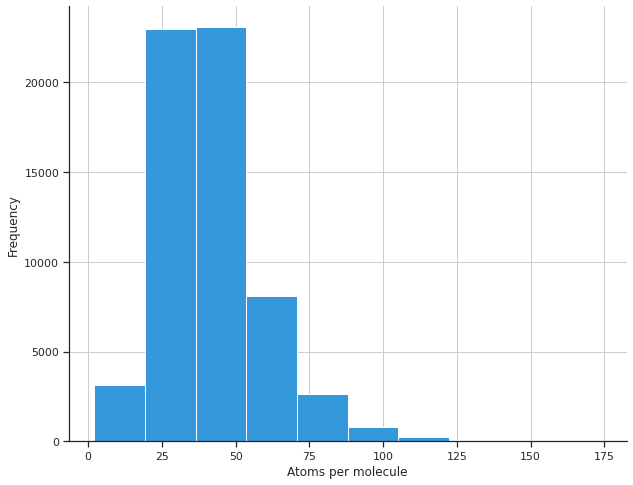

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
df_subset_clean.number_of_atoms.hist(color ='#3498DB')
ax.grid(True);
ax.set_xlabel('Atoms per molecule');
ax.set_ylabel('Frequency');
plt.savefig('atom_count.png', dpi = 600, bbox_inches = 'tight')
plt.show()

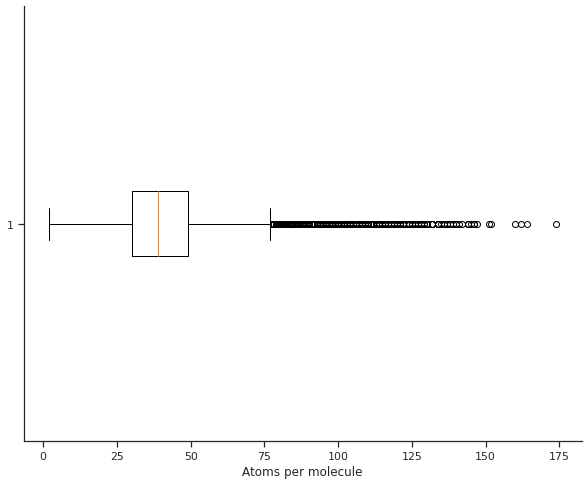

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(df_subset_clean.number_of_atoms, vert = False)
ax.set_xlabel('Atoms per molecule');
plt.savefig('atom_number_outliers.png', dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
# To contain the size of the coulomb matrix descriptor within a reasonable value,
# outliers are going to be removed from the dataset

df_subset_clean.number_of_atoms.describe()

count    61037.000000
mean        41.691466
std         16.836468
min          2.000000
25%         30.000000
50%         39.000000
75%         49.000000
max        174.000000
Name: number_of_atoms, dtype: float64

In [ ]:
# Percentiles
q1, q3 = np.percentile(df_subset_clean.number_of_atoms.values, [25, 75])
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
q1, q3, iqr, upper, lower

(30.0, 49.0, 19.0, 77.5, 1.5)

In [ ]:
# New box plot without outliers
mask = (df_subset_clean.number_of_atoms > lower) & (df_subset_clean.number_of_atoms < upper)
new = df_subset_clean.loc[mask].reset_index(drop = True)
len(df_subset_clean), len(new)

(61037, 58672)

In [ ]:
new.number_of_atoms.max()

77

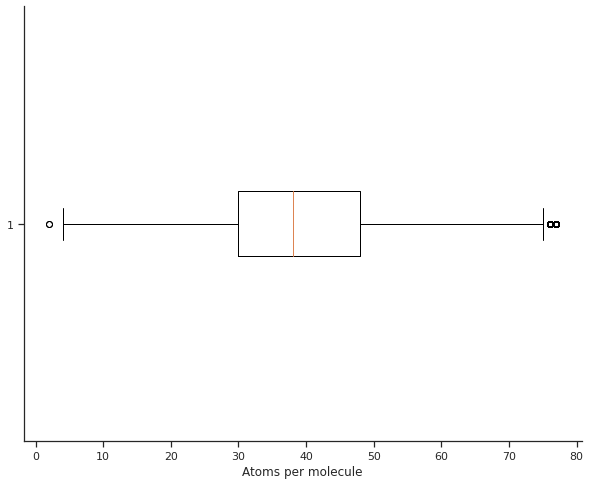

In [ ]:
# New dataset boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(new.number_of_atoms, vert = False)
ax.set_xlabel('Atoms per molecule');
plt.savefig('atom_number_clean.png', dpi = 600, bbox_inches = 'tight')
plt.show()

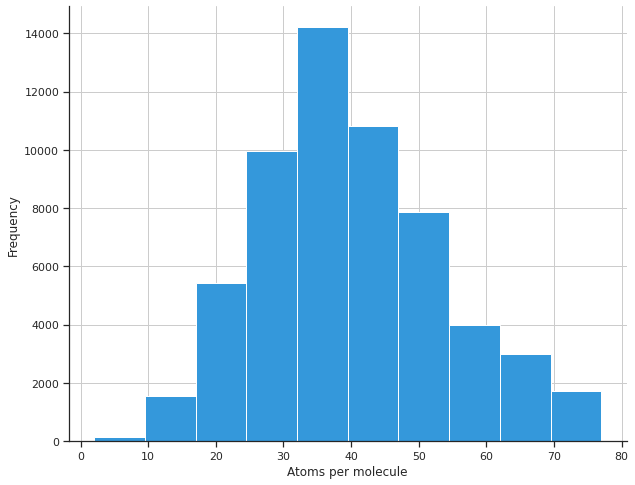

In [ ]:
# New distribution
fig, ax = plt.subplots(figsize=(10,8))
new.number_of_atoms.hist(color ='#3498DB')
ax.grid(True);
ax.set_xlabel('Atoms per molecule');
ax.set_ylabel('Frequency');
plt.savefig('atom_count_clean.png', dpi = 600, bbox_inches = 'tight')
plt.show()

Now the number of atoms per molecule has a distribution which looks more like a gaussian.

In [ ]:
new.number_of_atoms.describe()

count    58672.000000
mean        39.711668
std         13.670603
min          2.000000
25%         30.000000
50%         38.000000
75%         48.000000
max         77.000000
Name: number_of_atoms, dtype: float64

In [ ]:
# Assign the new dataframe to the old one
df_subset_clean = new

### 2.5: Enriching the data with more features

In [ ]:
df_subset_clean['tpsa'] = df_subset_clean['mol'].apply(lambda x: Descriptors.TPSA(x)) #https://en.wikipedia.org/wiki/Polar_surface_area
df_subset_clean['mol_w'] = df_subset_clean['mol'].apply(lambda x: Descriptors.ExactMolWt(x)) # https://en.wikipedia.org/wiki/Molecular_mass
df_subset_clean['num_valence_electrons'] = df_subset_clean['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x)) # https://en.wikipedia.org/wiki/Valence_electron
df_subset_clean['num_heteroatoms'] = df_subset_clean['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [ ]:
df_subset_clean.head(2)

,refcode_csd,canonical_smiles,number_of_atoms,xyz_pbe_relaxed,total_energy_pbe,mol,species,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,ABAFEQ,Cc1ccc(cc1)S(=O)(=O)N[C@H](c1nnc(o1)SCc1ccc(cc...,45,"{'O': [['39.55724515', '33.75271314', '38.4091...",-63908.261677,<rdkit.Chem.rdchem.Mol object at 0x7f5aae12fc90>,"{O, C, S, N, H, Cl}",85.09,423.047811,142,9
1,ABEDOC,N#CC(=C(c1ccccc1)c1ccccc1)[C@H](c1ccccc1)NS(=O...,55,"{'C': [['8.74281024', '13.44863575', '23.16378...",-47344.131203,<rdkit.Chem.rdchem.Mol object at 0x7f5aae12fb10>,"{O, C, S, N, H}",69.96,450.140199,162,5


In [ ]:
# Plotting some random molecules of the dataset
dopts = rdMolDraw2D.MolDrawOptions()
filename = 'mymolecules'

number_of_molecules = 6
to_draw = random.sample(range(0, len(df_subset_clean)), number_of_molecules)

mols = df_subset_clean["mol"][to_draw]
img = Draw.MolsToGridImage(mols, molsPerRow=3, useSVG=True,
                           legends=list(df["canonical_smiles"][to_draw].values),
                           drawOptions=dopts)

# Saving the file
if filename is not None:
    if not filename.endswith('.svg'):
        filename += '.svg'
    with open(filename, 'w') as f:
        f.write(img)

## Step 3: Deep Learning

###3.1: Preliminary steps

#### a) Embedding SMILES for DL processing
TODO: Put this process in a preprocessing Keras layer

First, we're going to embed the molecules using a pre-trained model

In [ ]:
import requests

url = 'https://github.com/samoturk/mol2vec_notebooks/raw/master/Notebooks/model_300dim.pkl'
file_to_download = requests.get(url, allow_redirects=True)

open('model_300dim.pkl', 'wb').write(file_to_download.content)

26567327

In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [ ]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec  # https://radimrehurek.com/gensim/index.html#install
w2vec_model = word2vec.Word2Vec.load('model_300dim.pkl') # Download from https://github.com/samoturk/mol2vec_notebo

In [ ]:
#Constructing sentences
df_subset_clean['sentence'] = df_subset_clean.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df_subset_clean['mol2vec'] = [DfVec(x) for x in sentences2vec(df_subset_clean['sentence'], w2vec_model, unseen='UNK')]

In [ ]:
df_subset_clean['mol2vec']=df_subset_clean['mol2vec'].apply(lambda x: x.vec)

In [ ]:
df_subset_clean.columns.values.tolist()

['refcode_csd',
 'canonical_smiles',
 'number_of_atoms',
 'xyz_pbe_relaxed',
 'total_energy_pbe',
 'mol',
 'species',
 'tpsa',
 'mol_w',
 'num_valence_electrons',
 'num_heteroatoms',
 'sentence',
 'mol2vec']

In [ ]:
final_dataset_columns=['xyz_pbe_relaxed',
 'tpsa',
 'mol_w',
 'num_valence_electrons',
 'num_heteroatoms',
 'number_of_atoms',
 'mol2vec',
'total_energy_pbe']

final_dataset = df_subset_clean[final_dataset_columns]
final_dataset.head(2)

,xyz_pbe_relaxed,tpsa,mol_w,num_valence_electrons,num_heteroatoms,number_of_atoms,mol2vec,total_energy_pbe
0,"{'O': [['39.55724515', '33.75271314', '38.4091...",85.09,423.047811,142,9,45,"[-9.885212, 7.283, -11.909391, 2.714392, -7.30...",-63908.261677
1,"{'C': [['8.74281024', '13.44863575', '23.16378...",69.96,450.140199,162,5,55,"[-10.063227, 10.888024, -20.65452, 0.42244783,...",-47344.131203


In [ ]:
# DFT calculations are expensive, so we would like to built a model capable of infering the molecule energy from their atom positions and species

#### b) Converting molecules into ASE atoms

In [ ]:
# Step 1: Get all the atom values in the dataset
dict_positions = final_dataset.xyz_pbe_relaxed
species = []
for dictionary in dict_positions:
  for key, value in dictionary.items():
    if key not in species:
      species.append(key)

len(species)

16

In [ ]:
# Step 2: creating new column into the dataset with proper format for ase
def dict_to_tuples (x):
  """
  Takes in a dictionary of xyz and returns an array of tuples usable in Atoms.
  """
  positions = []
  names = []
  for key, value in x.items():
    for position in value:
      names.append(key)
      positions.append(tuple(map(lambda x: float(x), position)))
  return names, positions

In [ ]:
final_dataset['xyz_pbe_relaxed'] = final_dataset['xyz_pbe_relaxed'].apply(dict_to_tuples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_dataset.head(2)

,xyz_pbe_relaxed,tpsa,mol_w,num_valence_electrons,num_heteroatoms,number_of_atoms,mol2vec,total_energy_pbe
0,"([O, O, O, S, S, C, C, C, C, C, C, C, C, C, C,...",85.09,423.047811,142,9,45,"[-9.885212, 7.283, -11.909391, 2.714392, -7.30...",-63908.261677
1,"([C, C, C, C, C, C, C, C, C, C, C, C, C, C, C,...",69.96,450.140199,162,5,55,"[-10.063227, 10.888024, -20.65452, 0.42244783,...",-47344.131203


In [ ]:
# Converting this last column into Atoms objects. This function cannot be parallelized
final_dataset['xyz_pbe_relaxed'] =  final_dataset['xyz_pbe_relaxed'].apply(lambda x: Atoms(x[0], x[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_dataset.head(2)

,xyz_pbe_relaxed,tpsa,mol_w,num_valence_electrons,num_heteroatoms,number_of_atoms,mol2vec,total_energy_pbe
0,"(Atom('O', [39.55724515, 33.75271314, 38.40917...",85.09,423.047811,142,9,45,"[-9.885212, 7.283, -11.909391, 2.714392, -7.30...",-63908.261677
1,"(Atom('C', [8.74281024, 13.44863575, 23.163783...",69.96,450.140199,162,5,55,"[-10.063227, 10.888024, -20.65452, 0.42244783,...",-47344.131203


#### c) Creating MBTR descriptor


In [ ]:
# Defining descriptor parameters
k1 = {
    "geometry": {"function": "atomic_number"},
    "grid": {"min": 1, "max": 85, "sigma": 0.1, "n": 20}  # Max atomic number is
                                                          # astatine
}

k2 = {
    "geometry": {"function": "inverse_distance"},
    "grid": {"min": 0.1, "max": 1, "sigma": 0.02, "n": 20}, # No distance smaller than 1 A
    "weighting": {"function": "exp", "r_cut": 10, "threshold": 1e-3}
}

k3 = {
    "geometry": {"function": "cosine"},
    "grid": {"min": -1, "max": 1, "sigma": 0.02, "n": 20},
    "weighting" : {"function": "exp", "r_cut": 10, "threshold": 1e-3}
}

In [ ]:
# Instantiating the descriptor and determining number of features
mbtr = MBTR(species = species,
            periodic = False,
            k1 = k1,
            k2 = k2,
            k3 = k3,
            flatten = False,
            sparse = False,
            normalization = 'l2_each')
print(f"Number of features: {mbtr.get_number_of_features()}")

Number of features: 46560


#### d) Creating Coulomb Matrix descriptor

In [ ]:
final_dataset

,xyz_pbe_relaxed,tpsa,mol_w,num_valence_electrons,num_heteroatoms,number_of_atoms,mol2vec,total_energy_pbe
0,"(Atom('O', [39.55724515, 33.75271314, 38.40917...",85.09,423.047811,142,9,45,"[-9.885212, 7.283, -11.909391, 2.714392, -7.30...",-63908.261677
1,"(Atom('C', [8.74281024, 13.44863575, 23.163783...",69.96,450.140199,162,5,55,"[-10.063227, 10.888024, -20.65452, 0.42244783,...",-47344.131203
2,"(Atom('N', [23.84904338, 42.50577669, 35.03884...",51.81,229.030983,78,5,23,"[-5.338256, 3.8927343, -6.896216, -0.27919152,...",-28915.979909
3,"(Atom('C', [36.52340453, 39.6406703, 25.169233...",34.14,228.062029,82,4,28,"[-4.85507, 5.27727, -9.770724, 2.1801903, -2.5...",-29310.525400
4,"(Atom('C', [3.95256786, 17.67855833, 24.828774...",123.58,226.022586,84,8,22,"[-3.7424397, 6.9630003, -7.5874896, 3.2785816,...",-23659.206412
...,...,...,...,...,...,...,...,...
58667,"(Atom('C', [22.26969809, 41.92804704, 35.46939...",78.90,420.251189,168,6,66,"[-11.613864, 11.018429, -15.99478, 4.44409, -5...",-37759.078750
58668,"(Atom('O', [33.93699398, 43.81820335, 40.73492...",61.69,308.011933,102,6,30,"[-6.1590996, 6.9757314, -8.373731, 0.45949158,...",-46914.426056
58669,"(Atom('C', [22.97323141, 39.02044458, 27.93148...",0.00,208.125201,80,0,32,"[-10.404796, 8.853079, -10.362222, -3.2704961,...",-16847.126386
58670,"(Atom('O', [56.17414946, 59.56569287, 49.15323...",92.78,576.012133,182,10,57,"[-10.337876, 9.518248, -17.89608, 0.178429, -7...",-134363.234235


In [ ]:
max(final_dataset.number_of_atoms)

77

In [ ]:
coulomb = CoulombMatrix(max(final_dataset.number_of_atoms), permutation='sorted_l2', sigma=None, seed=None, flatten=False, sparse=False)

In [ ]:
final_dataset['xyz_pbe_relaxed'] = final_dataset['xyz_pbe_relaxed'].apply(lambda x: coulomb.create(x, n_jobs = 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_dataset.head()

,xyz_pbe_relaxed,tpsa,mol_w,num_valence_electrons,num_heteroatoms,number_of_atoms,mol2vec,total_energy_pbe
0,"[[448.79438598087216, 27.680258698657525, 38.7...",85.09,423.047811,142,9,45,"[-9.885212, 7.283, -11.909391, 2.714392, -7.30...",-63908.261677
1,"[[388.0234410266618, 88.3620608430697, 88.4759...",69.96,450.140199,162,5,55,"[-10.063227, 10.888024, -20.65452, 0.42244783,...",-47344.131203
2,"[[388.0234410266618, 31.899214051089785, 35.50...",51.81,229.030983,78,5,23,"[-5.338256, 3.8927343, -6.896216, -0.27919152,...",-28915.979909
3,"[[388.0234410266618, 54.70566279609604, 88.163...",34.14,228.062029,82,4,28,"[-4.85507, 5.27727, -9.770724, 2.1801903, -2.5...",-29310.525400
4,"[[73.51669471981023, 12.068875880710928, 29.22...",123.58,226.022586,84,8,22,"[-3.7424397, 6.9630003, -7.5874896, 3.2785816,...",-23659.206412


In [ ]:
final_dataset_np = final_dataset.to_numpy()
final_dataset_np

In [ ]:
final_dataset_np[:, :-1]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Splitting training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_dataset_np[:, :-1], final_dataset_np[:, -1], random_state = 0)

In [ ]:
# Saving the arrays to Google Drive
vals_to_save = np.savez('/content/drive/MyDrive/m1507656/data_clean.npz', **{'X_train' : X_train,
                'X_test' : X_test,
                'y_train' : y_train,
                'y_test' : y_test})

In [ ]:
# Testing if load properly
test = np.load('/content/drive/MyDrive/m1507656/data_clean.npz', allow_pickle = True)
test['X_train']

array([[array([[2539.41283766,  109.2096523 ,   60.34746597, ...,    0.        ,
                   0.        ,    0.        ],
               [ 109.2096523 ,   36.8581052 ,   13.02029401, ...,    0.        ,
                   0.        ,    0.        ],
               [  60.34746597,   13.02029401,   73.51669472, ...,    0.        ,
                   0.        ,    0.        ],
               ...,
               [   0.        ,    0.        ,    0.        , ...,    0.        ,
                   0.        ,    0.        ],
               [   0.        ,    0.        ,    0.        , ...,    0.        ,
                   0.        ,    0.        ],
               [   0.        ,    0.        ,    0.        , ...,    0.        ,
                   0.        ,    0.        ]])                                 ,
        64.35, 243.984739628, ..., 5, 22,
        array([ -4.7533927 ,   2.703595  ,  -5.9512    ,  -1.0334702 ,
                -4.0429864 ,  -7.0697536 ,   4.4678574 ,  -3.279